In [326]:
import pandas as pd
import numpy as np
import tensorflow as tf

import os, sys
import json
from os import listdir
from os.path import isfile, join
import shutil 

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import cv2

from random import randrange
from random import shuffle

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import scipy.io

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.models import load_model

In [327]:
tf.random.set_seed(42)
np.random.seed(42)

In [328]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [329]:
if tf.test.gpu_device_name():

  # GPU connected
  print('GPU Connected')

  # Use mixed_float16 only wheb there is a GPU
  tf.keras.mixed_precision.set_global_policy(policy="mixed_float16")

else:

  # No GPU connected
  print('No GPU Connected')

print(tf.keras.mixed_precision.global_policy())

No GPU Connected
<Policy "float32">


In [330]:
is_download_cihp_dataset = False

run_model_parsing_3 = False

In [331]:
saved_models_path = '/content/gdrive/MyDrive/Saved-Models'

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [332]:
def get_file_paths_at_index(root_dir, index=0):

  """
  get a list of datapoints at an index from each sub directory
  """
  
  if os.path.exists(root_dir):

    result_files = []
    for root, dirs, files in os.walk(root_dir):
        if files and len(files) > index:
            result_files.append(os.path.join(root, sorted(files)[index]))

    return sorted(result_files)

  else:
    print('No such directory found: ', root_dir)

In [333]:
def move_all_files_and_sub_dirs(source, destination):

  """
  Moves all files and sub-directories at root level of a directory to another place 
  along with all there contents
  """

  root_dir = list(os.walk(source))[0][0]
  sub_dir_and_files = [os.path.join(root_dir, i) for i in (list(os.walk(source))[0][1] + list(os.walk(source))[0][2])]

  for item in sub_dir_and_files:

    shutil.move(item, destination)

In [334]:
%%time
if is_download_cihp_dataset:

  !pip install --upgrade --no-cache-dir gdown

  !wget https://drive.google.com/uc?id=1B9A9UCJYMwTL4oBEo4RZfbMZMaZhKJaz
  !gdown 1B9A9UCJYMwTL4oBEo4RZfbMZMaZhKJaz

  !unzip -q /content/instance-level-human-parsing.zip -d CIHP

  # Remove ATR dataset as we do not need it
  shutil.rmtree('/content/CIHP/ICCV15_fashion_dataset(ATR)')

  # Move CIHP dataset folders from tree of sub-dirs to dir "/content/CIHP"
  move_all_files_and_sub_dirs('/content/CIHP/instance-level_human_parsing/instance-level_human_parsing', '/content/CIHP')

  # Remove empty directories from dataset
  shutil.rmtree('/content/CIHP/instance-level_human_parsing') 

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 12.9 µs


In [335]:
def get_files_in_dir(dir_path):

  """
  Return a list of file names in a given directory
  """

  if os.path.exists(dir_path):
    files = sorted([f for f in listdir(dir_path) if isfile(join(dir_path, f))])
    return files

  else:
    print('No such directory found: ', dir_path)

In [336]:
def merge_two_list(list1, list2):
      
    merged_list = [(list1[i], list2[i]) for i in range(0, len(list1))]
    return merged_list

In [337]:
def shuffle_and_ratio_data(images, masks, image_root_path, mask_root_path, dataset_ratio=1):

  images_len = len(images)
  masks_len = len(masks)

  # make image and masks tuples, shuffle the data and then return given percentage of that data
  image_mask_tuples = merge_two_list(images, masks)
  shuffle(image_mask_tuples)
  image_mask_tuples_per = image_mask_tuples[:int(images_len * dataset_ratio)]

  images_result = [os.path.join(image_root_path, x[0]) for x in image_mask_tuples_per]
  masks_result = [os.path.join(mask_root_path, x[1]) for x in image_mask_tuples_per]

  return images_result, masks_result

In [338]:
def get_class_labels():

  # class labels
  # background was not mentioned in readme file but its color code was present in mat file at first index
  class_labels = [
      "Background", # 0
      "Hat", # 1
      "Hair", # 2
      "Glove", # 3
      "Sunglasses", # 4 
      "UpperClothes", # 5, shirt
      "Dress", # 6, wore by women like formal with short+pant
      "Coat", # 7
      "Socks", # 8
      "Pants", # 9
      "Torso-skin", # 10, means neck
      "Scarf", # 11
      "Skirt", # 12
      "Face", # 13
      "Left-arm", # 14
      "Right-arm", # 15
      "Left-leg", # 16
      "Right-leg", # 17
      "Left-shoe", # 18
      "Right-shoe", # 19
  ]

  return class_labels

In [339]:
class_labels = get_class_labels()
len(class_labels)

20

In [340]:
cihp_test_dir = '/content/CIHP/Testing'
cihp_train_dir = '/content/CIHP/Training'
cihp_valid_dir = '/content/CIHP/Validation'

In [341]:
images_train = get_files_in_dir(os.path.join(cihp_train_dir, 'Images'))
masks_train = get_files_in_dir(os.path.join(cihp_train_dir, 'Categories'))

images_valid = get_files_in_dir(os.path.join(cihp_valid_dir, 'Images'))
masks_valid = get_files_in_dir(os.path.join(cihp_valid_dir, 'Categories'))

images_test = get_files_in_dir(os.path.join(cihp_test_dir, 'Images'))

print(len(images_train), len(masks_train), len(images_valid), len(masks_valid), len(images_test))

28280 28280 5000 5000 5000


In [342]:
train_x, train_y = shuffle_and_ratio_data(images_train, masks_train, image_root_path='/content/CIHP/Training/Images', mask_root_path='/content/CIHP/Training/Category_ids', dataset_ratio=0.1)
train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, test_size=0.2, shuffle=False,)

valid_x, valid_y = shuffle_and_ratio_data(images_valid, masks_valid, image_root_path='/content/CIHP/Validation/Images', mask_root_path='/content/CIHP/Validation/Category_ids', dataset_ratio=0.1)

len(train_x), len(train_y), len(test_x), len(test_y), len(valid_x), len(valid_y)

(2262, 2262, 566, 566, 500, 500)

In [343]:
# def remove_items_array(array_items, remove_items):

#   return [i for i in array_items if i not in remove_items]

# skip_labels = [1, 6, 7, 11]

# replace_array = [[[1, 2, 4, 10, 11], 13], [[3, 15], 14], [[7], 5], [[8, 17, 18, 19], 16], [[12], 9]]
# replace_array = [[remove_items_array(i,skip_labels),j] for i,j in replace_array]

# replaced_indexes = np.array(np.concatenate([i for i, j in replace_array]), dtype = np.uint8)

# remaining_indexes = remove_items_array([i for i in  np.arange(20) if i not in replaced_indexes], skip_labels)

# print(replace_array)
# print(replaced_indexes)
# print(remaining_indexes)

# merged_class_labels = []
# for i in range(len(class_labels)):
#   if i not in replaced_indexes and i not in skip_labels:
#     merged_class_labels.append(class_labels[i])

# print(merged_class_labels)
# print(len(merged_class_labels))

# def merge_classes(mask_image_array):

#   """
#   replace_array = [ [ [ replace_from ], replace_to] ]
#   """

#   # mask_original = cv2.imread(mask_path, cv2.COLOR_BGR2RGB)
#   mask_merged = mask_image_array

#   for i, j in replace_array:
#     mask_merged = np.select([mask_merged == k for k in i], [j for _ in i], mask_merged)

#   # after merging values are from 0-19 so we make them 0-6
#   for i in remaining_indexes:
#     mask_merged = np.select([mask_merged == i], [np.where(remaining_indexes == i)], mask_merged)

#   return mask_merged

In [344]:
# ['Background', 'UpperClothes', 'Dress', 'Pants', 'Face', 'Left-arm', 'Left-leg']
# replace_array = [[[1, 2, 4, 10, 11], 13], [[3, 15], 14], [[7], 5], [[8, 17, 18, 19], 16], [[12], 9]]

replace_array = [[[1, 2, 4, 10, 11], 13], [[3, 15], 14], [[7], 5], [[8, 17, 18, 19], 16], [[12], 9]]
replaced_indexes = np.concatenate([i for i, j in replace_array])

remaining_indexes = [i for i in  np.arange(20) if i not in replaced_indexes]

print(replaced_indexes)
print(remaining_indexes)

merged_class_labels = []
for i in range(len(class_labels)):
  if i not in replaced_indexes:
    merged_class_labels.append(class_labels[i])

print(merged_class_labels)
print(len(merged_class_labels))

def merge_classes(mask_image_array):

  """
  replace_array = [ [ [ replace_from ], replace_to] ]
  """

  # mask_original = cv2.imread(mask_path, cv2.COLOR_BGR2RGB)
  mask_merged = mask_image_array

  for i, j in replace_array:
    mask_merged = np.select([mask_merged == k for k in i], [j for _ in i], mask_merged)

  # after merging values are from 0-19 so we make them 0-6
  for i in remaining_indexes:
    mask_merged = np.select([mask_merged == i], [np.where(remaining_indexes == i)], mask_merged)

  return mask_merged

[ 1  2  4 10 11  3 15  7  8 17 18 19 12]
[0, 5, 6, 9, 13, 14, 16]
['Background', 'UpperClothes', 'Dress', 'Pants', 'Face', 'Left-arm', 'Left-leg']
7


In [345]:
is_allow_merge = True

# IMG_HEIGHT = 400
# IMG_WIDTH = 480
IMG_HEIGHT = 320
IMG_WIDTH = 416

N_CHANNELS = 3

N_CLASSES = len(merged_class_labels) if is_allow_merge else len(class_labels)

BATCH_SIZE_PARSING = 32

print(N_CLASSES)

7


In [346]:
def process_image_and_mask(image_path, mask_path):

  image = cv2.imread(image_path)
  image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT)) # (W,H)
  image = image/255. 
  image = image.astype(np.float32)

  mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
  mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT)) # (W,H)

  mask_orig = mask
  mask_processed = mask

  # This will merge unwanted mask classes
  if is_allow_merge:
    mask_processed = merge_classes(mask_image_array = mask)

  # mask normalization is different from simply /255, below we are doing mask normalization, it is one-hot encoding in our case
  mask_objects = []
  for gray_scale_value in range(N_CLASSES):
    # we are setting cmap (binary mask) values to true where ever the color maches the color on mask
    # in this way we will get 20 images each of which shows an object, for every mask image
    # and we are doing this for all pixels
    cmap = np.all(np.equal(np.expand_dims(mask_processed, axis=-1), gray_scale_value), axis=-1)
    mask_objects.append(cmap)

  # stack adds a new dimension to the array and stacks all images into a single array
  # it makes 20 images of (400, 480) into an array of (400, 480, 20)
  # (400, 480, 20) => this gives one-hot encoding where out of 20 items in the array any one is 1 which shows class value
  # we are doing this one-hot encoding thing beacuse this gives good results for training
  mask_stack = np.stack(mask_objects, axis=-1)
  mask_stack = mask_stack.astype(np.uint8)

  # print(mask_stack)

  return image, mask_orig, mask_processed, mask_stack

/content/CIHP/Validation/Images/0000821.jpg /content/CIHP/Validation/Category_ids/0000821.png
(320, 416, 7) (320, 416)


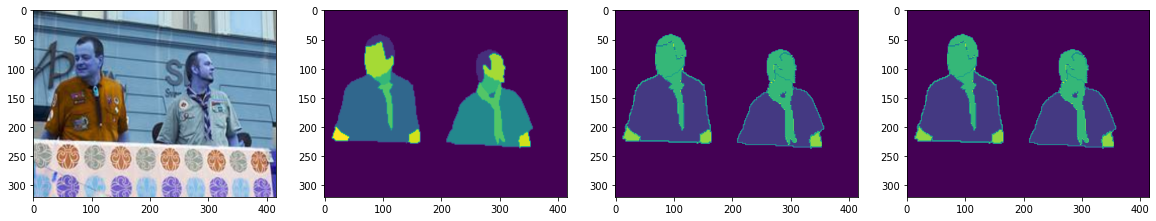

In [347]:
image_path = get_file_paths_at_index('/content/CIHP/Validation/Images', 70)[0]
mask_path = get_file_paths_at_index('/content/CIHP/Validation/Category_ids', 70)[0]

print(image_path, mask_path)

image, mask_orig, mask_processed, mask_stack = process_image_and_mask(image_path, mask_path)

fig = plt.figure(figsize=(20, 14))

fig.add_subplot(1, 4, 1)
plt.imshow(image)

fig.add_subplot(1, 4, 2)
plt.imshow(mask_orig)

fig.add_subplot(1, 4, 3)
plt.imshow(mask_processed)

mask_stack_org = np.argmax(mask_stack, axis=-1)
mask_stack_org = mask_stack_org.astype(np.float32)

fig.add_subplot(1, 4, 4)
plt.imshow(mask_stack_org)

print(mask_stack.shape, mask_stack_org.shape)

In [348]:
len(train_x), len(train_y), len(test_x), len(test_y), len(valid_x), len(valid_y)

(2262, 2262, 566, 566, 500, 500)

(320, 416, 3) (320, 416, 7) (320, 416)


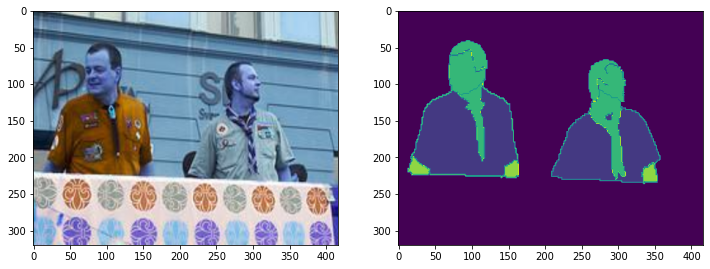

In [349]:
# x, y = train_data_2[0]
image_path = get_file_paths_at_index('/content/CIHP/Validation/Images', 70)[0]
mask_path = get_file_paths_at_index('/content/CIHP/Validation/Category_ids', 70)[0]

x, a, b, y = process_image_and_mask(image_path, mask_path)

image = x

mask = np.argmax(y, axis=-1)
mask = mask.astype(np.float32)

fig = plt.figure(figsize=(12, 8))

fig.add_subplot(1, 2, 1)
plt.imshow(image)

fig.add_subplot(1, 2, 2)
plt.imshow(mask)

print(image.shape, y.shape, mask.shape)

In [350]:
# we have to create this function for piplining, beacuse when we want to read (decode) tensor object we have to do this in an intermediate function

def preprocess(x, y):
    def f(x, y):
        x = x.decode()
        y = y.decode()

        processed_reult = process_image_and_mask(x, y)
        image, _, _, mask_stack = processed_reult

        return image, mask_stack

    image, mask_stack = tf.numpy_function(f, [x, y], [tf.float32, tf.uint8])
    image.set_shape([IMG_HEIGHT, IMG_WIDTH, N_CHANNELS])
    mask_stack.set_shape([IMG_HEIGHT, IMG_WIDTH, N_CLASSES])

    return image, mask_stack

In [351]:
# def filter_fn(image, mask):

#   # skip_labels

#   # mask_check = tf.argmax(mask_stack, axis=-1)
#   # mask_check = mask.astype(np.float32)
#   # mask_check = cv2.imread(mask, cv2.IMREAD_GRAYSCALE)
  
#   # print(np.amax(mask_check))
#   # print(mask)

#   # for i in skip_labels:
#   #   if i in mask_check:
#   #     return False

  
#   return True

In [352]:
# create the pipeline

def tf_dataset(image_paths, mask_paths, batch_size=32):

  return tf.data.Dataset.from_tensor_slices((image_paths, mask_paths)).map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [353]:
train_data_3 = tf_dataset(train_x, train_y, batch_size=BATCH_SIZE_PARSING)
valid_data_3 = tf_dataset(valid_x, valid_y, batch_size=BATCH_SIZE_PARSING)
test_data_3 = tf_dataset(test_x, test_y, batch_size=BATCH_SIZE_PARSING)

train_data_3, valid_data_3, test_data_3

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 320, 416, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 320, 416, 7), dtype=tf.uint8, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 320, 416, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 320, 416, 7), dtype=tf.uint8, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 320, 416, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 320, 416, 7), dtype=tf.uint8, name=None))>)

(320, 416, 3) (320, 416, 7) (320, 416)
tf.Tensor([0 0 0 1 0 0 0], shape=(7,), dtype=uint8)
0.0 6.0
{0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0}


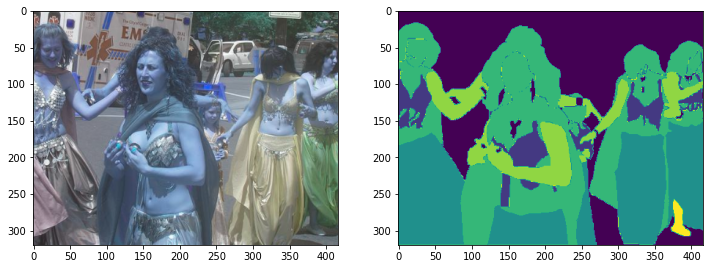

In [354]:
for x, y in train_data_3.take(1):

  index = 2

  image = x[index]

  mask = np.argmax(y[index], axis=-1)
  mask = mask.astype(np.float32)

  fig = plt.figure(figsize=(12, 8))

  fig.add_subplot(1, 2, 1)
  plt.imshow(image)

  fig.add_subplot(1, 2, 2)
  plt.imshow(mask)

  print(image.shape, y[index].shape, mask.shape)

  print(y[index][-4][1])

  print(np.amin(mask), np.amax(mask))

  print(set(mask.flatten()))

  break